# Rotational Invariance in Convolutional Neural Networks
Rotational Invariance of CNNs will be calculated and visualized here.  

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import utils
reload(utils)

Using gpu device 0: GeForce GTX 770 (CNMeM is enabled)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Using Theano backend.
Couldn't import dot_parser, loading of dot files will not be possible.


<module 'utils' from 'utils.pyc'>

In [3]:
(X_train, Y_train), (X_test, Y_test) = utils.load_data()

In [4]:
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 10)
(10000, 10)


## The Model

In [5]:
model_name = 'model-big-50'
model = utils.load_model(model_name)

In [6]:
loss, accuracy = model.evaluate(X_test, Y_test, show_accuracy=True)
print "Loss:", loss
print "Accuracy:", accuracy

10000/10000 [==============================] - 0s     
Loss: 0.756164794827
Accuracy: 0.7486


## Augment the data  
Add rotated versions of all images to the dataset and test the accuracy of the model on these versions.  

In [7]:
rotations = [90, 180, 270]

In [8]:
X_test_aug = utils.augment_data(X_test, rotations)  # Images are processed in parallel using all CPUs

X_test_aug_flat = [x for X_test_group in X_test_aug for x in X_test_group]

Y_test_aug_flat = []
for y in Y_test:
    Y_test_aug_flat += [y for _ in range(len(rotations)+1)]

loss, accuracy = model.evaluate(np.array(X_test_aug_flat), np.array(Y_test_aug_flat), show_accuracy=True)
print "Loss on augmented Test data:", loss
print "Accuracy on augmented Test data:", accuracy

40000/40000 [==============================] - 2s     
Loss on augmented Test data: 1.99319999619
Accuracy on augmented Test data: 0.401125


In [9]:
group_accuracy = []  # list of lists: [[index, acc of original, group acc]...]

for i, image_group in enumerate(X_test_aug):
    prediction = model.predict_classes(image_group, verbose=0)
    truth = Y_test[i].argmax()
    group_acc = (prediction == truth).mean()
    org_acc = (prediction[0] == truth).mean()
    group_accuracy += [(i, org_acc, group_acc)]

group_accuracy = np.array(group_accuracy)

In [10]:
_, org_acc, grp_acc = group_accuracy.mean(axis=0)
print "Original accuracy on Test set:\t%f" % org_acc
print "Group accuracy on Test set:\t%f" % grp_acc


Original accuracy on Test set:	0.748600
Group accuracy on Test set:	0.401125


## Visualize image groups

In [11]:
group_accuracy_low = filter(lambda x: x[1]==1.0 and x[2]>0 and x[2]<=0.25, group_accuracy)
group_accuracy_high = filter(lambda x: x[1]==1.0 and x[2]==1.0, group_accuracy)

In [12]:
indices_min_acc = [int(x[0]) for x in group_accuracy_low[:10]]
indices_max_acc = [int(x[0]) for x in group_accuracy_high[:10]]
print "Groups with min accuracy (>0):\t", indices_min_acc
print "Groups with max accuracy:\t", indices_max_acc

Groups with min accuracy (>0):	[1, 2, 5, 6, 9, 13, 26, 27, 40, 42]
Groups with max accuracy:	[0, 4, 11, 14, 19, 31, 32, 38, 39, 41]


In [13]:
# Compare covariant matrices of augmented images with original
for index in indices_min_acc:
    image_group = X_test_aug[index]
    diffs = []
    for i in range(1, len(image_group)):
        diffs += [np.linalg.norm(utils.augment_image(image_group[0])[1] - 
                                        utils.augment_image(image_group[i])[1])]
    diffs = np.array(diffs)
    print diffs.mean()

290.072
235.849
88.6282
134.056
182.589
85.3465
109.854
154.897
131.54
93.9601


In [14]:
# Compare covariant matrices of augmented images with original
for index in indices_max_acc:
    image_group = X_test_aug[index]
    diffs = []
    for i in range(1, len(image_group)):
        diffs += [np.linalg.norm(utils.augment_image(image_group[0])[1] - 
                                        utils.augment_image(image_group[i])[1])]
    diffs = np.array(diffs)
    print diffs.mean()

114.733
78.3873
178.857
100.249
111.27
77.3735
79.3442
156.411
101.554
36.9601


Groups with min accuracy (>0)
First image is the original, second is the covariance matrix, and third is the real part of the FFT
Index: 1
Index: 2
Index: 5
Index: 6
Index: 9
Index: 13
Index: 26
Index: 27
Index: 40
Index: 42


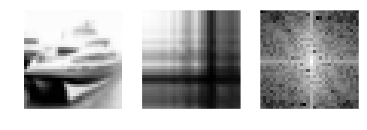

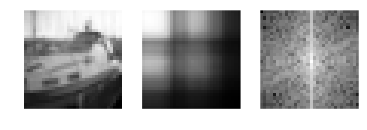

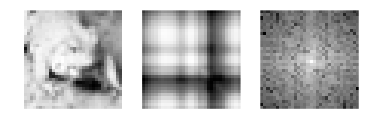

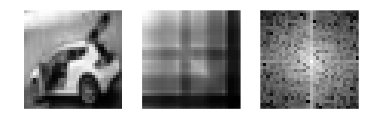

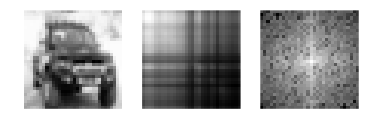

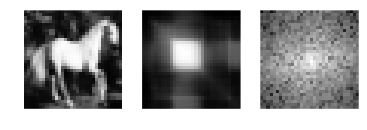

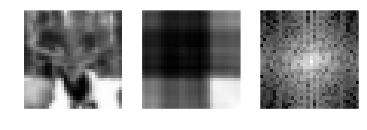

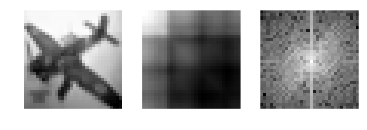

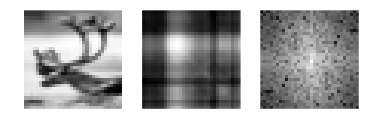

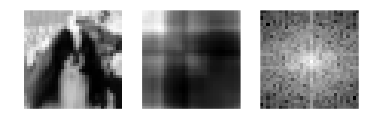

In [15]:
print "Groups with min accuracy (>0)"
print "First image is the original, second is the covariance matrix, and third is the real part of the FFT"
for i in indices_min_acc:
    print "Index: %d" % i
    utils.visualize_augmented_images(utils.augment_image(X_test_aug[i][0]))

Group with max accuracy
First image is the original, second is the covariance matrix, and third is the real part of the FFT
Index: 0
Index: 4
Index: 11
Index: 14
Index: 19
Index: 31
Index: 32
Index: 38
Index: 39
Index: 41


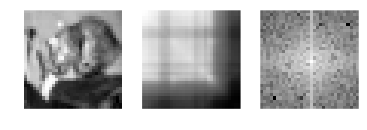

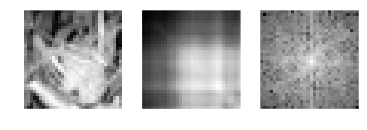

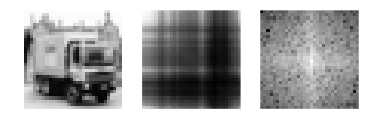

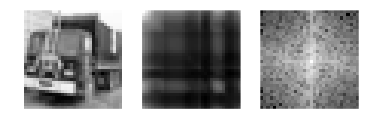

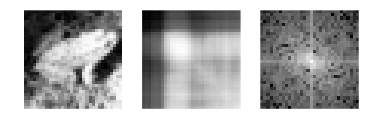

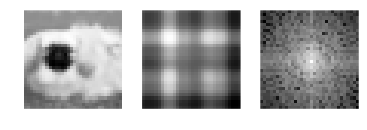

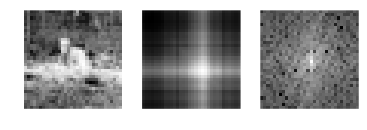

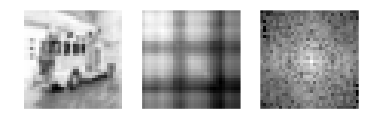

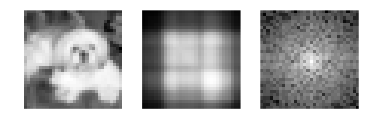

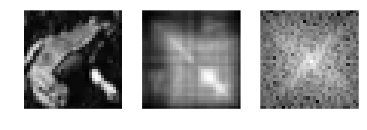

In [16]:
print "Group with max accuracy"
print "First image is the original, second is the covariance matrix, and third is the real part of the FFT"
for i in indices_max_acc:
    print "Index: %d" % i
    utils.visualize_augmented_images(utils.augment_image(X_test_aug[i][0]))

## Compare the feature maps
Compare the feature maps of the original image with its augmented versions.  

### Comparison for image group with low accuracy (>0)

In [90]:
def extract_mean_diffs(all_diffs):
    mean_diffs_low = []
    for i, layer_diffs in all_diffs:
        diff_means = []
        for layer_diff in layer_diffs:
            layer_num, diffs = layer_diff
            diff_mean = []
            for aug_image_num, diff in diffs:
                diff_mean += [diff.mean()]
            diff_mean = np.array(diff_mean)
            diff_means += [diff_mean.mean()]
        mean_diffs_low += [diff_means]
    return np.array(mean_diffs_low)

In [85]:
reload(utils)

<module 'utils' from 'utils.py'>

In [86]:
image_group.shape

(6, 3, 32, 32)

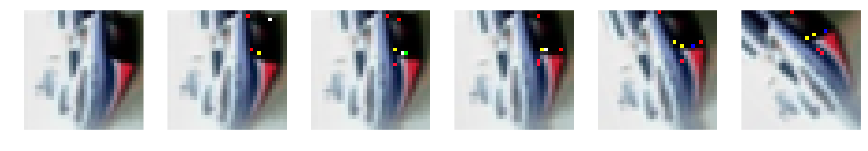

In [87]:
image_group = X_test_aug[1]
utils.visualize_image_group(image_group)

In [88]:
all_diffs_low = []  #  List of tuples: [(index, [(layer_num, (aug image #, [diffs]))])]
for i in indices_min_acc[:2]:
    image_group = X_test_aug[i]
    image_diffs = []
    for layer_num in range(1,9):
        image_diffs += [(layer_num, utils.diff_at_layer(image_group, layer_num, model, verbose=False))]
    all_diffs_low += [(i, image_diffs)]

In [91]:
mean_diffs_low = extract_mean_diffs(all_diffs_low)
print "Mean diffs across layers (1 to 8):", mean_diffs_low.mean(axis=0)

Mean diffs across layers (1 to 8): [ 2.58132356  4.52535643  3.39457769  3.39457769  3.18865532  2.49309711
  1.81437742  1.81437742]


### Comparison for image group with high accuracy

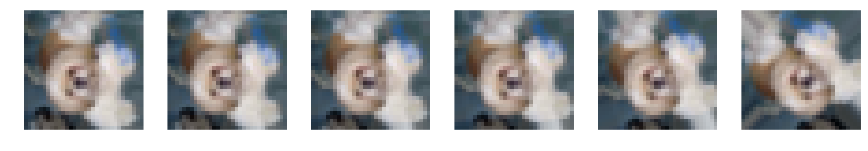

In [92]:
image_group = X_test_aug[indices_max_acc[8]]
utils.visualize_image_group(image_group)

In [93]:
all_diffs_high = []  #  List of tuples: [(index, [(layer_num, (aug image #, [diffs]))])]
for i in indices_max_acc[:2]:
    image_group = X_test_aug[i]
    image_diffs = []
    for layer_num in range(1,9):
        image_diffs += [(layer_num, utils.diff_at_layer(image_group, layer_num, model, verbose=False))]
    all_diffs_high += [(i, image_diffs)]

In [94]:
mean_diffs_high = extract_mean_diffs(all_diffs_high)
print "Mean diffs across layers (1 to 8):", mean_diffs_high.mean(axis=0)

Mean diffs across layers (1 to 8): [ 5.69814973  8.4061096   6.23042961  6.23042961  5.17844872  3.70744472
  2.81343368  2.81343368]


In [ ]:
all_diffs_high = []  #  List of tuples: (layer_num, image #, diffs)
for layer_num in range(1,9):
    all_diffs_high += [(layer_num, utils.diff_at_layer(image_group, layer_num, model))]

In [ ]:
all_diffs_high